# ICT4SM GOUP 14 LAB 2

In [4]:
import pymongo as pm 
from pymongo import MongoClient
import pprint 
import datetime
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timedelta

from sklearn.neighbors import KernelDensity
import numpy as np


client = pm.MongoClient('bigdatadb.polito.it:27017',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)



db_car2go = client["carsharing"]["ictts_PermanentBookings"]
db_enjoy = client["carsharing"]["ictts_enjoy_PermanentBookings"]



## Tasks

### 1 For carsharing data, check if the booking records requires to be filtered to get valid rentals. Derive the OD matrix based on the zones of Torino

Filtering function

In [38]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Progress bar
from datetime import datetime

# Load zones from GeoJSON file
zones = gpd.read_file("./Zone/TorinoZonescol.geojson").to_crs("EPSG:4326")

# Fetch data in small batches with progress tracking
def fetch_all_data_in_batches(collection, collection_name, batch_size=10000):
    cursor = collection.find({}, {"init_loc": 1, "final_loc": 1, "init_time": 1}, no_cursor_timeout=True)
    with tqdm(desc=f"Fetching {collection_name} data", unit="records") as pbar:
        try:
            batch_data = []
            for document in cursor:
                batch_data.append(document)
                pbar.update(1)
                if len(batch_data) >= batch_size:
                    yield pd.DataFrame(batch_data)
                    batch_data = []
            if batch_data:
                yield pd.DataFrame(batch_data)
        finally:
            cursor.close()

# Filter valid rentals (init_loc and final_loc must be distinct)
def filter_valid_rentals(df):
    return df[df["init_loc"] != df["final_loc"]]

# Assign zones to trips
def assign_zones(df, zones):
    if "zone_id" not in zones.columns:
        zones["zone_id"] = range(len(zones))

    df["ORI_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=df["init_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]

    df["DST_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=df["final_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]

    return df.dropna(subset=["ORI_ZONE", "DST_ZONE"]).reset_index(drop=True)

# Add hour, day, and date columns based on init_time
def add_time_columns(df):
    df["hour"] = pd.to_datetime(df["init_time"], unit="s").dt.hour
    df["day"] = pd.to_datetime(df["init_time"], unit="s").dt.weekday
    df["date"] = pd.to_datetime(df["init_time"], unit="s").dt.date  # Adding date column
    return df

# Normalize OD matrix
def normalize_od_matrix_bidirectional(df):
    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="count", fill_value=0)

    for _ in range(10):
        # Normalize rows
        row_sums = pivot.sum(axis=1)
        pivot = pivot.div(row_sums, axis=0).fillna(0)

        # Normalize columns
        col_sums = pivot.sum(axis=0)
        pivot = pivot.div(col_sums, axis=1).fillna(0)

    return pivot.stack().reset_index(name="normalized_count")

# Generate OD matrix with bidirectional normalization
def generate_od_matrix_with_bidirectional_normalization(df, zones):
    df_with_zones = assign_zones(df, zones)
    df_with_zones = add_time_columns(df_with_zones)

    # Group by Origin, Destination, Hour, Day, and Date
    od_matrix = df_with_zones.groupby(["ORI_ZONE", "DST_ZONE", "hour", "day", "date"]).size().reset_index(name="count")
    normalized_matrix = normalize_od_matrix_bidirectional(od_matrix)
    normalized_matrix = pd.merge(normalized_matrix, od_matrix, on=["ORI_ZONE", "DST_ZONE"], how="left")
    return normalized_matrix

# Save OD matrix to CSV
def save_od_matrix_to_csv(od_matrix, filename):
    od_matrix.to_csv(filename, index=False)

# Process and save OD matrices for Car2GO and Enjoy
def process_and_save_matrices(db_collection, collection_name, zones, output_file):
    all_od_matrices = []
    for batch in fetch_all_data_in_batches(db_collection, collection_name):
        filtered_batch = filter_valid_rentals(batch)
        od_matrix = generate_od_matrix_with_bidirectional_normalization(filtered_batch, zones)
        all_od_matrices.append(od_matrix)

    final_od_matrix = pd.concat(all_od_matrices, ignore_index=True)
    save_od_matrix_to_csv(final_od_matrix, output_file)
    print(f"Saved {collection_name} OD matrix to {output_file}")

# Processing Car2GO and Enjoy data
print("Processing Car2GO data...")
process_and_save_matrices(db_car2go, "Car2GO", zones, "car2go_od_matrix.csv")

print("Processing Enjoy data...")
process_and_save_matrices(db_enjoy, "Enjoy", zones, "enjoy_od_matrix.csv")

print("Processing completed.")


C:\Users\sartr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymongo\synchronous\collection.py:1920: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


Processing Car2GO data...


Fetching Car2GO data: 121667records [00:41, 2950.66records/s]
C:\Users\sartr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymongo\synchronous\collection.py:1920: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


Saved Car2GO OD matrix to car2go_od_matrix.csv
Processing Enjoy data...


Fetching Enjoy data: 97173records [00:12, 7709.95records/s] 


Saved Enjoy OD matrix to enjoy_od_matrix.csv
Processing completed.


### a. Compute OD matrices on different periods (weekdays vs weekends, daytime vs night-time). Is it possible to spot any difference? 

Plotting Car2GO OD matrices for different periods...


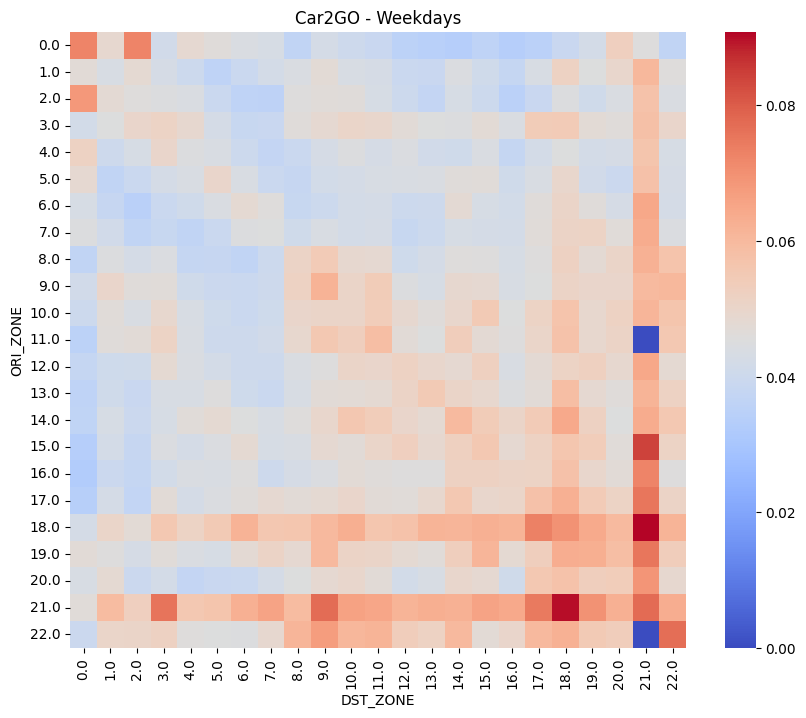

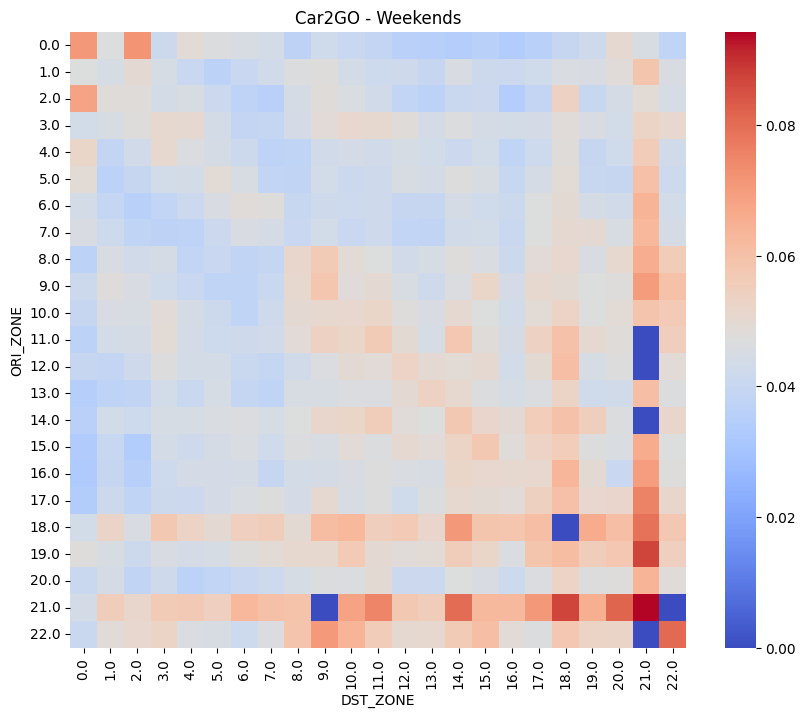

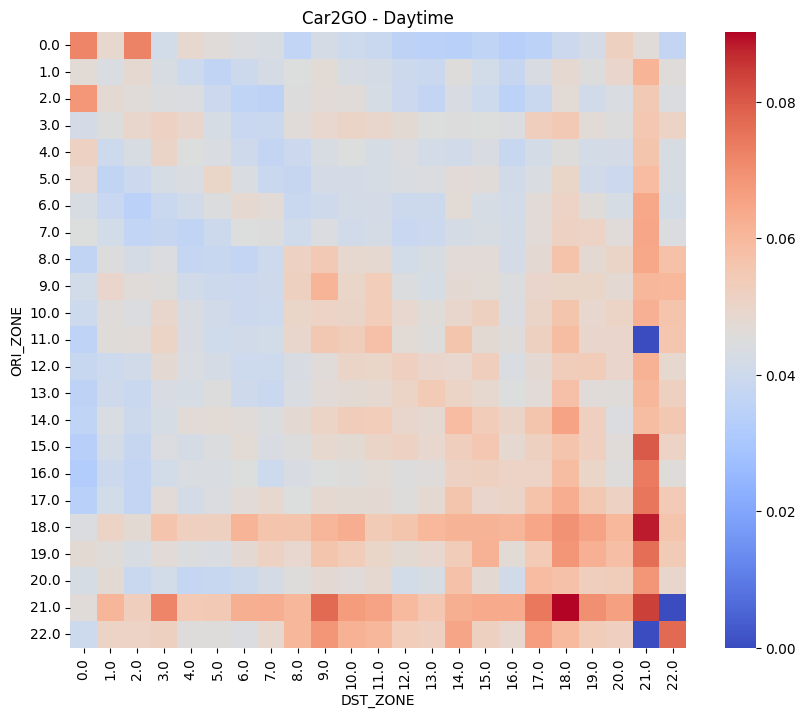

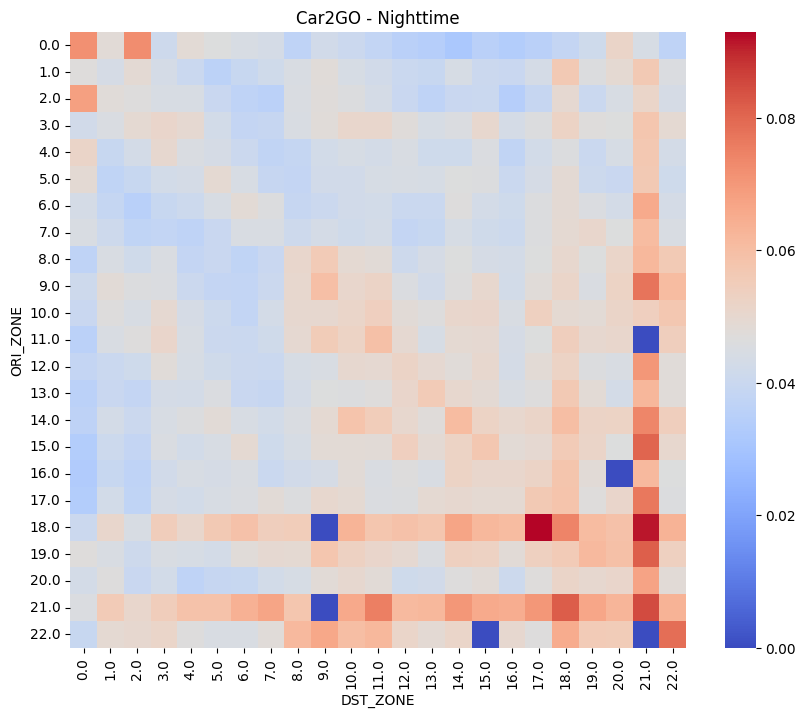

Plotting Car2GO OD matrices for same period diferent week


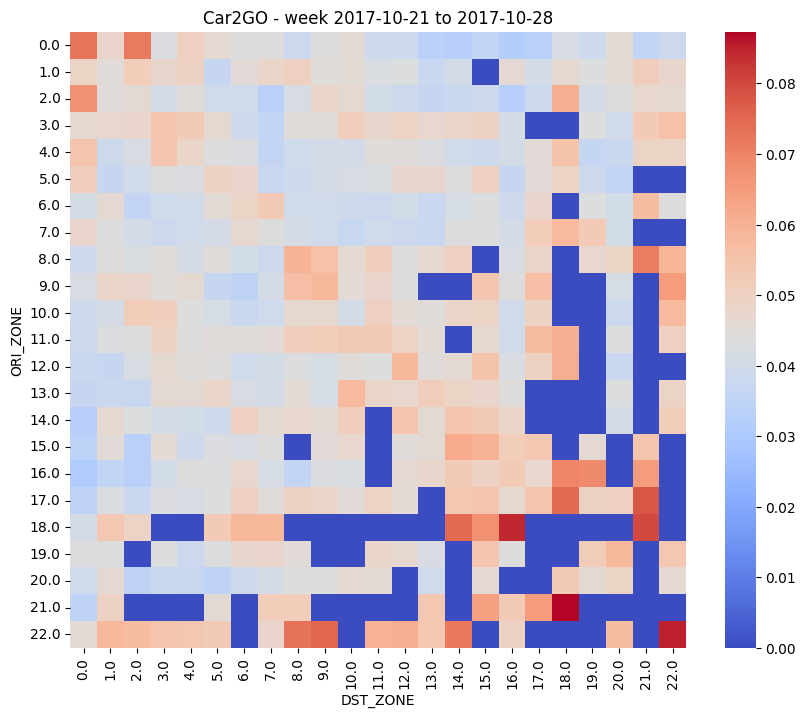

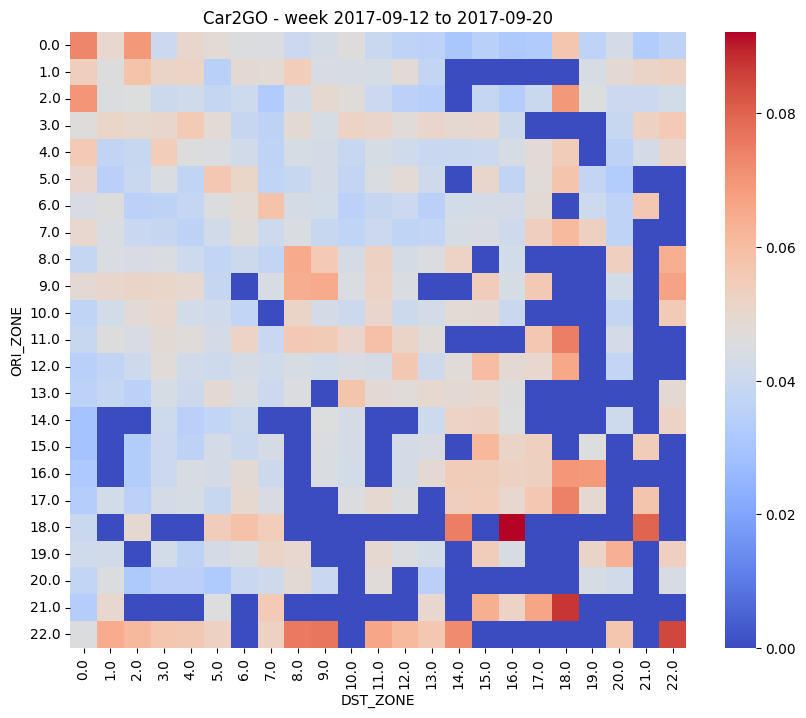

Plotting comparison between Car2GO and Enjoy...


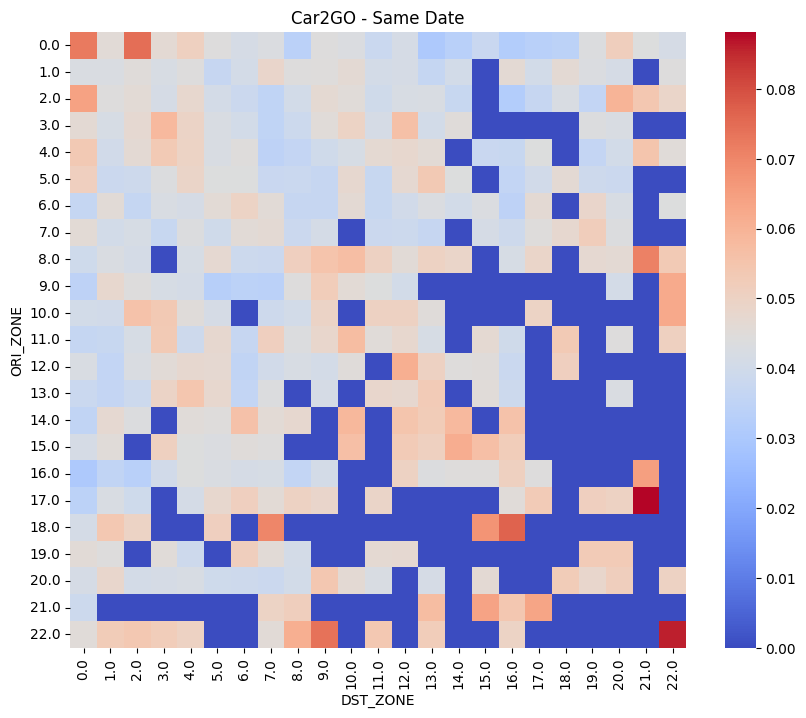

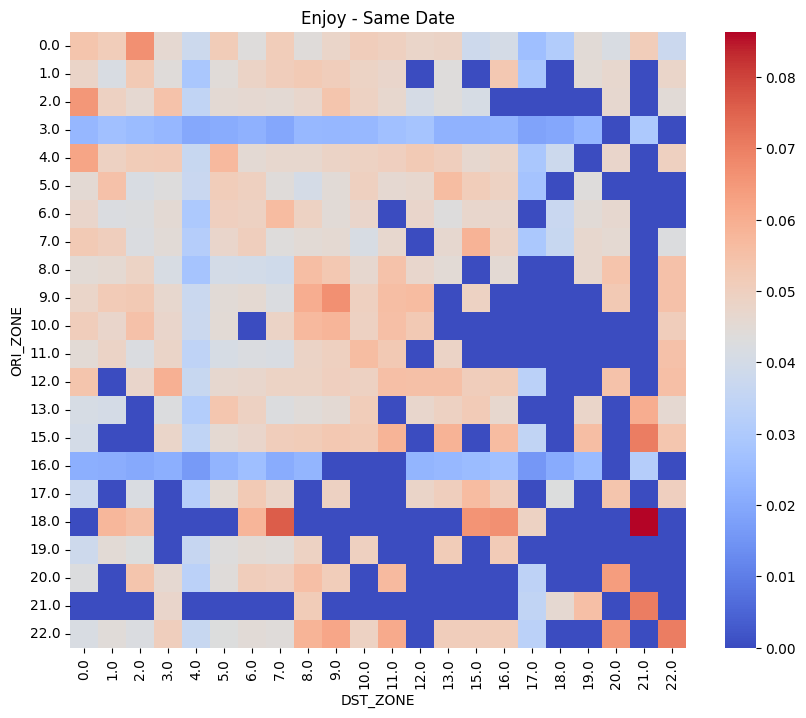

Processing and plotting completed.


In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def filter_od_matrix(df, day_filter=None, hour_filter=None, date_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 6:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 6:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    if date_filter is not None:
        df = df[(pd.to_datetime(df["date"]).isin(pd.to_datetime(date_filter)))]
    return df

def plot_od_matrix(df, title):
    if df.empty:
        print(f"No data available for {title}. Skipping plot.")
        return

    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, cmap="coolwarm", square=True, cbar=True)
    plt.title(title)
    plt.xlabel("DST_ZONE")
    plt.ylabel("ORI_ZONE")
    plt.show()

# Load OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")

# A. Compute OD matrices for different periods (weekdays vs weekends, daytime vs nighttime)
print("Plotting Car2GO OD matrices for different periods...")
weekday_od = filter_od_matrix(car2go_od_matrix, day_filter=range(0, 5))
plot_od_matrix(weekday_od, "Car2GO - Weekdays")

weekend_od = filter_od_matrix(car2go_od_matrix, day_filter=[5, 6])
plot_od_matrix(weekend_od, "Car2GO - Weekends")

daytime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(6, 18))
plot_od_matrix(daytime_od, "Car2GO - Daytime")

nighttime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(18, 6))
plot_od_matrix(nighttime_od, "Car2GO - Nighttime")

# B. Compute OD matrices for same period (weekdays but different weeks)
print("Plotting Car2GO OD matrices for same period diferent week")
week1_dates = ['2017-10-21', '2017-10-28']
week2_dates = ['2017-10-13', '2017-10-21']
week1_od = filter_od_matrix(car2go_od_matrix, day_filter=[0, 5], date_filter=week1_dates)
week2_od = filter_od_matrix(car2go_od_matrix, day_filter=[0, 5], date_filter=week2_dates)

plot_od_matrix(week1_od, "Car2GO - week 2017-10-21 to 2017-10-28")
plot_od_matrix(week2_od, "Car2GO - week 2017-09-12 to 2017-09-20")

# C. Compare OD matrices for the same date between 
print("Plotting comparison between Car2GO and Enjoy...")
same_date = ['2017-10-28']
same_date_car2go = filter_od_matrix(car2go_od_matrix, date_filter=same_date)
same_date_enjoy = filter_od_matrix(enjoy_od_matrix, date_filter=same_date)

plot_od_matrix(same_date_car2go, "Car2GO - Same Date")
plot_od_matrix(same_date_enjoy, "Enjoy - Same Date")

print("Processing and plotting completed.")

### b. Consider the same period, compute OD matrices on different dates (e.g., OD matrices of weekdays in two different weeks). is it possible to spot any difference? How does the different compare with different periods? 

### c. Consider the same period, compute OD matrices on same date for Car2GO and Enjoy. Is there any difference between different platforms? How does it compare with previous ones? 

## 2. Derive metrics to compute the similarity between OD matrices.

In [68]:
# Compute similarity metrics
def compute_similarity_metrics(matrix_a, matrix_b):
    zones = sorted(set(matrix_a["ORI_ZONE"]).union(matrix_b["ORI_ZONE"]))
    combined_a = matrix_a.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0).reindex(index=zones, columns=zones, fill_value=0)
    combined_b = matrix_b.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0).reindex(index=zones, columns=zones, fill_value=0)

    a_flat = combined_a.values.flatten()
    b_flat = combined_b.values.flatten()

    absolute_difference = np.sum(np.abs(a_flat - b_flat))
    mse = np.mean((a_flat - b_flat) ** 2)
    rmse = np.sqrt(mse)

    return {
        "Absolute Difference": absolute_difference,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse
    }

# Similarity between Weekdays and Weekends
similarity_weekday_weekend = compute_similarity_metrics(weekday_od, weekend_od)
print("Similarity between Weekdays and Weekends:")
for metric, value in similarity_weekday_weekend.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Daytime and Nighttime
similarity_daytime_nighttime = compute_similarity_metrics(daytime_od, nighttime_od)
print("Similarity between Daytime and Nighttime:")
for metric, value in similarity_daytime_nighttime.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Week 1 and Week 2
similarity_weeks = compute_similarity_metrics(week1_od, week2_od)
print("Similarity between Week 1 and Week 2:")
for metric, value in similarity_weeks.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Car2GO and Enjoy on the same date
similarity_car2go_enjoy = compute_similarity_metrics(same_date_car2go, same_date_enjoy)
print("Similarity between Car2GO and Enjoy on the same date:")
for metric, value in similarity_car2go_enjoy.items():
    print(f"  {metric}: {value:.4f}")

# Generate completely random matrices from the same CSV structure
random_matrix_1 = car2go_od_matrix.sample(frac=1).reset_index(drop=True)  # Shuffle Car2GO data
random_matrix_2 = enjoy_od_matrix.sample(frac=1).reset_index(drop=True)  # Shuffle Enjoy data

# Ensure random matrices have the required columns and normalize
random_matrix_1 = random_matrix_1.groupby(["ORI_ZONE", "DST_ZONE"]).size().reset_index(name="count")
random_matrix_1["normalized_count"] = random_matrix_1["count"] / random_matrix_1["count"].sum()

random_matrix_2 = random_matrix_2.groupby(["ORI_ZONE", "DST_ZONE"]).size().reset_index(name="count")
random_matrix_2["normalized_count"] = random_matrix_2["count"] / random_matrix_2["count"].sum()

# Similarity between two completely random matrices
similarity_random = compute_similarity_metrics(random_matrix_1, random_matrix_2)
print("Similarity between two completely random matrices:")
for metric, value in similarity_random.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Enjoy (same day) and Car2GO (weekdays)
similarity_enjoy_car2go_weekdays = compute_similarity_metrics(same_date_enjoy, weekday_od)
print("Similarity between Enjoy (same day) and Car2GO (weekdays):")
for metric, value in similarity_enjoy_car2go_weekdays.items():
    print(f"  {metric}: {value:.4f}")


Similarity between Weekdays and Weekends:
  Absolute Difference: 1.3864
  Mean Squared Error: 0.0001
  Root Mean Squared Error: 0.0074
Similarity between Daytime and Nighttime:
  Absolute Difference: 1.1290
  Mean Squared Error: 0.0000
  Root Mean Squared Error: 0.0067
Similarity between Week 1 and Week 2:
  Absolute Difference: 2.7000
  Mean Squared Error: 0.0002
  Root Mean Squared Error: 0.0134
Similarity between Car2GO and Enjoy on the same date:
  Absolute Difference: 8.8930
  Mean Squared Error: 0.0007
  Root Mean Squared Error: 0.0258
Similarity between two completely random matrices:
  Absolute Difference: 0.2324
  Mean Squared Error: 0.0000
  Root Mean Squared Error: 0.0007
Similarity between Enjoy (same day) and Car2GO (weekdays):
  Absolute Difference: 11.9326
  Mean Squared Error: 0.0010
  Root Mean Squared Error: 0.0317


## 3. Compute OD matrices for unipol and IMQ

In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load IMQ Tables
spostamenti = pd.read_csv('./IMQData/spostamenti.csv')  # Replace with actual file path
interviste = pd.read_csv('./IMQData/interviste.csv')    # Replace with actual file path
tab_sesso = pd.read_csv('./IMQData/tab_sesso.csv')     # Replace with actual file path

# Step 1: Merge Tables
# Join Spostamenti and Interviste tables
imq_data = pd.merge(spostamenti, interviste, on='ID_INT', how='inner')

# Inspect column names after merging
print("Merged dataset columns:", imq_data.columns)

# Step 2: Select Correct Columns
# Use the correct columns based on the headers after merging
imq_data['SESSO'] = imq_data['SESSO_y']  # Gender from Interviste
imq_data['FASCIA_ETA'] = imq_data['FASCIA_ETA_y']  # Age group from Interviste
imq_data['COD_ZONA_PAR'] = imq_data['COD_ZONA_PAR']  # Origin zone from Spostamenti
imq_data['COD_ZONA_ARR'] = imq_data['COD_ZONA_ARR']  # Destination zone from Spostamenti

# Drop rows with missing zones (optional, for safety)
imq_data = imq_data.dropna(subset=['COD_ZONA_PAR', 'COD_ZONA_ARR'])

# Map Gender using Tab_Sesso
gender_mapping = dict(zip(tab_sesso['Cod_Sex'], tab_sesso['Label']))
imq_data['SESSO'] = imq_data['SESSO'].map(gender_mapping)

# Step 3: Define Functions
def compute_od_matrix(data, origin_col, destination_col, group_col=None):
    if group_col:
        od_matrix = data.groupby([origin_col, destination_col, group_col]).size().unstack(fill_value=0)
    else:
        od_matrix = data.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    return od_matrix.fillna(0)

def normalize_matrix(matrix):

    row_sums = matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return matrix.div(row_sums, axis=0)

def compute_similarity(matrix1, matrix2, metric='cosine'):
    if metric == 'cosine':
        return cosine_similarity(matrix1.values.flatten().reshape(1, -1),
                                 matrix2.values.flatten().reshape(1, -1))[0][0]
    elif metric == 'euclidean':
        return np.linalg.norm(matrix1.values.flatten() - matrix2.values.flatten())
    else:
        raise ValueError("Unsupported metric")

def analyze_gender_differences(data, gender_col, age_col, origin_col, destination_col):

    gender_differences = {}
    for gender in data[gender_col].unique():
        age_groups = data[age_col].unique()
        gender_grouped_matrices = []
        for age_group in age_groups:
            filtered_data = data[(data[gender_col] == gender) & 
                                 (data[age_col] == age_group)]
            od_matrix = compute_od_matrix(filtered_data, origin_col, destination_col)
            normalized_matrix = normalize_matrix(od_matrix)
            gender_grouped_matrices.append(normalized_matrix)
        # Compute similarities across age groups for this gender
        similarities = []
        for i in range(len(gender_grouped_matrices)):
            for j in range(i + 1, len(gender_grouped_matrices)):
                sim = compute_similarity(gender_grouped_matrices[i], gender_grouped_matrices[j])
                similarities.append(sim)
        gender_differences[gender] = np.mean(similarities) if similarities else 0
    return gender_differences

# Step 4: Compute OD Matrices
od_matrix_male = compute_od_matrix(imq_data[imq_data['SESSO'] == 'Maschi'], 'COD_ZONA_PAR', 'COD_ZONA_ARR')
od_matrix_female = compute_od_matrix(imq_data[imq_data['SESSO'] == 'Femmine'], 'COD_ZONA_PAR', 'COD_ZONA_ARR')

# Step 5: Normalize Matrices
od_matrix_male_norm = normalize_matrix(od_matrix_male)
od_matrix_female_norm = normalize_matrix(od_matrix_female)

# Step 6: Compute Similarity
if not od_matrix_male_norm.empty and not od_matrix_female_norm.empty:
    similarity_score = compute_similarity(od_matrix_male_norm, od_matrix_female_norm)
    print(f"Similarity Score (Male vs Female): {similarity_score}")
else:
    print("One or both OD matrices are empty, similarity cannot be computed.")

# Step 7: Analyze Gender Differences Across Age Groups
gender_diff = analyze_gender_differences(imq_data, 'SESSO', 'FASCIA_ETA', 'COD_ZONA_PAR', 'COD_ZONA_ARR')
print("Gender Differences in Mobility Across Age Groups (IMQ):", gender_diff)


C:\Users\sartr\AppData\Local\Temp\ipykernel_4612\3944165090.py:6: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  spostamenti = pd.read_csv('./IMQData/spostamenti.csv')  # Replace with actual file path


Merged dataset columns: Index(['ID_INT', 'PROGR_USC', 'PROGR_SPOST', 'SESSO_x', 'FASCIA_ETA_x',
       'COD_ZONA_RES_x', 'SCOPO', 'COD_ZONA_PAR', 'PROV_PAR', 'ORA_PAR',
       'COD_ZONA_ARR', 'PROV_ARR', 'ORA_ARR', 'USO_MEZZ', 'MEZZO1', 'MEZZO2',
       'MEZZO3', 'PAX_AUTO', 'NUM_LIN_URB', 'COD_ALTROURB', 'COD_ZONA_2M',
       'PROV_2M', 'ORA_2MEZZO', 'COD_ZONA_3M', 'PROV_3M', 'ORA_3MEZZO',
       'TASSO_CAMP_x', 'GIORNO', 'COD_ZONA_RES_y', 'RESIDENZA', 'SESSO_y',
       'FASCIA_ETA_y', 'TRASP', 'Q_USC', 'N_SPOST', 'N_AUTO', 'ATTIVITA',
       'TIPO_STUD', 'LAVORA', 'SETTORE_LAV', 'TITOLO_STUDIO', 'RESID_ANAGR',
       'TASSO_CAMP_y'],
      dtype='object')
Similarity Score (Male vs Female): 0.9801323204841034
Gender Differences in Mobility Across Age Groups (IMQ): {'Maschi': np.float64(0.8568250458916998), 'Femmine': np.float64(0.8474427048818803)}


RMSE Similarity (Male): 0.004329052295055308
RMSE Similarity (Female): 0.0039055797958056394


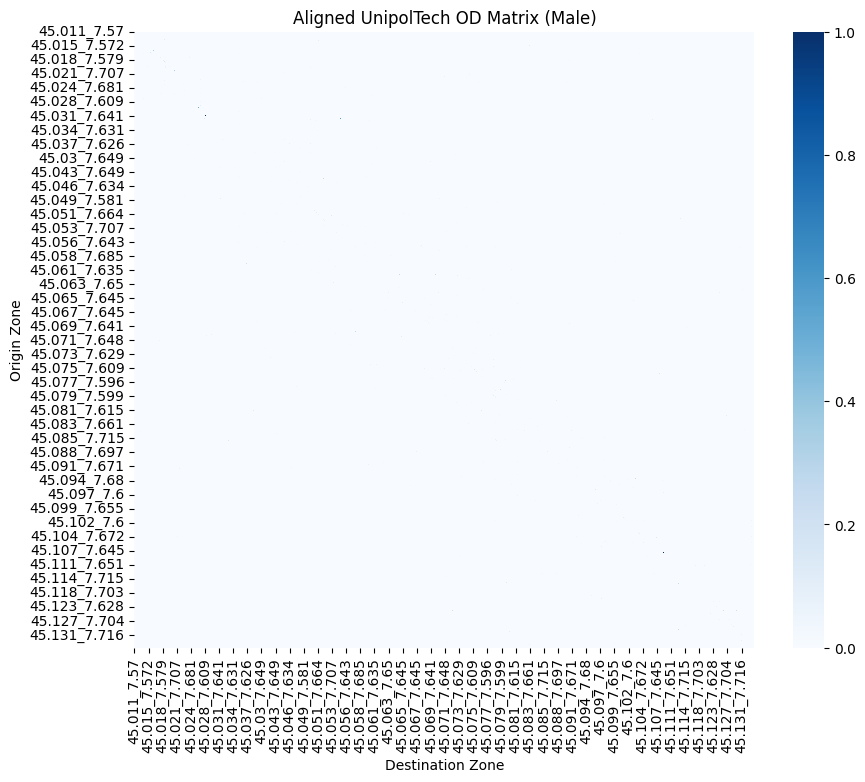

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load UnipolTech Data
info_to = pd.read_csv('Info_TO.csv')  
trips_od_to = pd.read_csv('Trips_OD_TO.csv')  

# Load IMQ Data
imq_data = pd.read_csv('./IMQData_Torino.csv')  

# Define OD Matrix Computation
def compute_od_matrix(data, origin_col, destination_col):
    """
    Computes an OD matrix from trip data.
    Args:
        data: DataFrame containing trip data
        origin_col: Column name for origin zones
        destination_col: Column name for destination zones
    Returns:
        OD Matrix (DataFrame)
    """
    od_matrix = data.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    return od_matrix

# Normalize OD matrix
def normalize_matrix(matrix):
    row_sums = matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return matrix.div(row_sums, axis=0)

# RMSE similarity metric
def compute_rmse(matrix1, matrix2):
    """
    Compute RMSE between two OD matrices.
    Args:
        matrix1: First OD matrix
        matrix2: Second OD matrix
    Returns:
        RMSE score
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape for RMSE computation.")
    return np.sqrt(((matrix1 - matrix2) ** 2).values.flatten().mean())

# Plot OD matrix
def plot_od_matrix(matrix, title):
    """
    Plots an OD matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='Blues', annot=False, cbar=True)
    plt.title(title)
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")
    plt.show()

    

# Step 1: Process UnipolTech Data
# Merge Info_TO and Trips_OD_TO using id_veicolo
unipol_merged = pd.merge(trips_od_to, info_to, on='id_veicolo')

# Map coordinates to zones (for simplicity, we assume lat/lon are mapped to fixed zones)
unipol_merged['ORI_ZONE'] = unipol_merged['lat_start'].astype(str) + "_" + unipol_merged['lon_start'].astype(str)
unipol_merged['DST_ZONE'] = unipol_merged['lat_stop'].astype(str) + "_" + unipol_merged['lon_stop'].astype(str)

# Compute OD Matrices for Male and Female
unipol_male = compute_od_matrix(unipol_merged[unipol_merged['genere'] == 'M'], 'ORI_ZONE', 'DST_ZONE')
unipol_female = compute_od_matrix(unipol_merged[unipol_merged['genere'] == 'F'], 'ORI_ZONE', 'DST_ZONE')

# Normalize UnipolTech OD matrices
unipol_male_norm = normalize_matrix(unipol_male)
unipol_female_norm = normalize_matrix(unipol_female)

# Step 2: Process IMQ Data
# Compute OD Matrices for Male and Female
imq_male = compute_od_matrix(imq_data[imq_data['GENDER'] == 1], 'ORI_ZONE', 'DST_ZONE')
imq_female = compute_od_matrix(imq_data[imq_data['GENDER'] == 2], 'ORI_ZONE', 'DST_ZONE')

# Normalize IMQ OD matrices
imq_male_norm = normalize_matrix(imq_male)
imq_female_norm = normalize_matrix(imq_female)

# Determine common zones across datasets
common_zones = sorted(
    set(unipol_male_norm.index).union(unipol_male_norm.columns)
    .union(imq_male_norm.index).union(imq_male_norm.columns)
)

# Reindex OD matrices to match the common zones
def align_matrix(matrix, common_zones):
    """
    Reindex the OD matrix to align with common zones.
    Missing rows/columns are filled with zeros.
    """
    return matrix.reindex(index=common_zones, columns=common_zones, fill_value=0)

# Align UnipolTech matrices
unipol_male_aligned = align_matrix(unipol_male_norm, common_zones)
unipol_female_aligned = align_matrix(unipol_female_norm, common_zones)

# Align IMQ matrices
imq_male_aligned = align_matrix(imq_male_norm, common_zones)
imq_female_aligned = align_matrix(imq_female_norm, common_zones)

# Compute RMSE for aligned matrices
male_rmse = compute_rmse(unipol_male_aligned, imq_male_aligned)
female_rmse = compute_rmse(unipol_female_aligned, imq_female_aligned)

print(f"RMSE Similarity (Male): {male_rmse}")
print(f"RMSE Similarity (Female): {female_rmse}")

# Plot Aligned OD Matrices
# UnipolTech Male and Female
plot_od_matrix(unipol_male_aligned, "Aligned UnipolTech OD Matrix (Male)")
plot_od_matrix(unipol_female_aligned, "Aligned UnipolTech OD Matrix (Female)")

# IMQ Male and Female
plot_od_matrix(imq_male_aligned, "Aligned IMQ OD Matrix (Male)")
plot_od_matrix(imq_female_aligned, "Aligned IMQ OD Matrix (Female)")


# Step 3: Compute RMSE for Gender
male_rmse = compute_rmse(unipol_male_norm, imq_male_norm)
female_rmse = compute_rmse(unipol_female_norm, imq_female_norm)

print(f"RMSE Similarity (Male): {male_rmse}")
print(f"RMSE Similarity (Female): {female_rmse}")

# Step 4: Plot OD Matrices
# Plot UnipolTech OD Matrices
plot_od_matrix(unipol_male_norm, "UnipolTech OD Matrix (Male)")
plot_od_matrix(unipol_female_norm, "UnipolTech OD Matrix (Female)")

# Plot IMQ OD Matrices
plot_od_matrix(imq_male_norm, "IMQ OD Matrix (Male)")
plot_od_matrix(imq_female_norm, "IMQ OD Matrix (Female)")
